In [ ]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, auc
import numpy as np
from typing import Tuple
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report

In [3]:
DATA_PATH = Path("../data")

In [4]:
df_withdrawals = pd.read_parquet(DATA_PATH / "zrive_advertiser_withdrawals.parquet")
df_advertiser = pd.read_parquet(DATA_PATH / "zrive_dim_advertiser.parquet")
df_monthly = pd.read_parquet(DATA_PATH / "zrive_fct_montly_snapshot_advertiser.parquet")

In [40]:
full_data = pd.read_parquet(DATA_PATH / "full_data.parquet")

In [41]:
full_data

,advertiser_zrive_id,period_int,monthly_published_ads,monthly_unique_published_ads,monthly_contracted_ads,monthly_leads,monthly_visits,monthly_oro_ads,monthly_plata_ads,monthly_destacados_ads,...,visits_per_published_ad_3_months_mean,visits_per_published_ad_3_months_mean_delta,leads_per_visit_3_months_mean,leads_per_visit_3_months_mean_delta,leads_per_shows_3_months_mean,leads_per_shows_3_months_mean_delta,invoice_per_published_ad_3_months_mean,invoice_per_published_ad_3_months_mean_delta,invoice_per_lead_3_months_mean,invoice_per_lead_3_months_mean_delta
0,1,202301,47,47,75,18,40890.0,6,6,6,...,870.000000,0.000000,0.000440,0.000000,0.000009,0.000000e+00,9.378723,0.000000,24.488889,0.000000
3302,1,202302,44,44,50,10,34740.0,3,3,1,...,829.772727,-40.227273,0.000364,-0.000076,0.000007,-1.546840e-06,9.971180,0.592456,35.484444,10.995556
1,2,202301,31,31,150,4,17970.0,10,10,4,...,579.677419,0.000000,0.000223,0.000000,0.000003,0.000000e+00,2.432258,0.000000,18.850000,0.000000
3303,2,202302,31,31,150,4,10695.0,10,10,4,...,462.338710,-117.338710,0.000298,0.000076,0.000004,3.487824e-07,2.101613,-0.330645,16.287500,-2.562500
6312,2,202303,47,47,150,6,7845.0,10,10,4,...,363.864104,-196.949211,0.000454,0.000311,0.000005,3.440795e-06,1.644338,-0.914550,12.763889,-7.047222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48233,6824,202408,8,8,10,0,3232.5,0,0,0,...,401.076389,2.986111,0.000169,-0.000169,0.000017,-1.698103e-05,0.000000,0.000000,0.000000,0.000000
50262,6824,202409,7,7,10,0,1980.0,0,0,0,...,349.528770,-66.671627,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
52295,6824,202410,6,6,10,0,2070.0,0,0,0,...,343.973214,1.026786,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
54286,6824,202411,6,6,10,1,2055.0,0,0,0,...,323.452381,19.047619,0.000162,0.000324,0.000016,3.251002e-05,0.000000,0.000000,0.000000,0.000000


In [42]:
column_order  = [
    "monthly_leads",
    "monthly_total_invoice",
    "monthly_visits",
    'month_period',
    "churn"
]
df_final = full_data[column_order]
df_final['churn'] = df_final['churn']*1

C:\Users\maick\AppData\Local\Temp\ipykernel_348\279242721.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['churn'] = df_final['churn']*1


In [22]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56335 entries, 0 to 56334
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   monthly_leads          56335 non-null  int64  
 1   monthly_total_invoice  56335 non-null  float64
 2   monthly_visits         56335 non-null  float64
 3   churn                  56335 non-null  int32  
dtypes: float64(2), int32(1), int64(1)
memory usage: 1.9 MB


In [33]:
def plot_metrics(
        model_name: str,
        y_pred: pd.Series,
        y_test: pd.Series,
        figure: Tuple[matplotlib.figure.Figure, np.array] = None
):
    precision_, recall_, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall_, precision_)

    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    if figure is None:
        fig, ax = plt.subplots(1, 2, figsize=(14, 7))
    else:
        fig, ax = figure
        
        
    ax[0].plot(recall_, precision_, label=f"{model_name}; AUC: {pr_auc:.2f}")
    ax[0].set_xlabel("recall")
    ax[0].set_ylabel("precision")
    ax[0].set_title(f"Precision-recall curve")
    ax[0].legend()

    ax[1].plot(fpr, tpr, label=f"AUC: {roc_auc:.2f}")
    ax[1].set_xlabel("FPR")
    ax[1].set_ylabel("TPR")
    ax[1].set_title(f"ROC curve")
    ax[1].legend()

In [34]:
train_df = df_final[
    (df_final['month_period'] >= '202303') &
    (df_final['month_period'] < '202401')
]

val_df = df_final[df_final['month_period'] == '202401']

label_col = 'churn'

In [35]:
def feature_label_split(df: pd.DataFrame, label_col: str) -> Tuple[pd.DataFrame, pd.Series]:
    return df.drop(label_col, axis=1), df[label_col]

X_train, y_train = feature_label_split(train_df, label_col)
X_val, y_val = feature_label_split(val_df, label_col)

In [37]:
train_cols =[
    "monthly_leads",
    "monthly_total_invoice",
    "monthly_visits"
    ]

In [45]:
X_train[train_cols]

,monthly_leads,monthly_total_invoice,monthly_visits
6312,6,34.3,7845.0
9162,4,61.7,13275.0
11878,16,34.3,16342.5
14493,12,0.0,13867.5
17035,7,6.9,11325.0
...,...,...,...
21876,8,0.0,13095.0
24155,13,0.0,8692.5
26379,3,0.0,6990.0
28595,1,0.0,5827.5


In [49]:
y_train.value_counts()

churn
0.0    22619
1.0     1903
Name: count, dtype: int64

In [ ]:
# model basic
lr = LogisticRegression(
    class_weight="balanced",
)

lr.fit(X_train[train_cols], y_train)

LogisticRegression(random_state=29)

In [44]:
y_train_pred_LogReg_ridge_model = lr.predict(X_train[train_cols])

print(
    "Report Train:\n", classification_report(y_train, y_train_pred_LogReg_ridge_model)
)

Report Train:
               precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     22619
         1.0       0.00      0.00      0.00      1903

    accuracy                           0.92     24522
   macro avg       0.46      0.50      0.48     24522
weighted avg       0.85      0.92      0.89     24522



c:\Users\maick\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\maick\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\maick\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

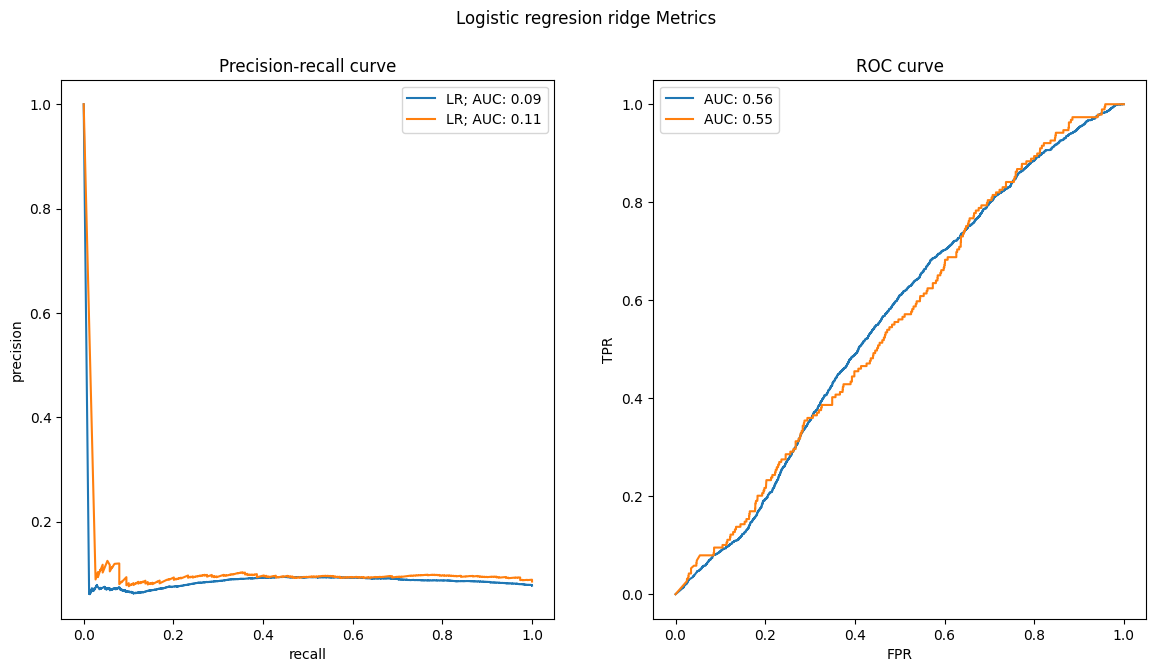

In [39]:
y_train_pred_LogReg_model = lr.predict(X_train[train_cols])
y_test_pred_LogReg_model = lr.predict(X_val[train_cols])

fig1, ax1 = plt.subplots(1, 2, figsize=(14, 7))
fig1.suptitle("Logistic regresion ridge Metrics")


val_proba = lr.predict_proba(X_train[train_cols])[:, 1]
plot_metrics(
    f"LR", y_pred=val_proba, y_test=train_df[label_col], figure=(fig1, ax1)
)

val_proba = lr.predict_proba(X_val[train_cols])[:, 1]
plot_metrics(
    f"LR", y_pred=val_proba, y_test=val_df[label_col], figure=(fig1, ax1)
)

In [ ]:
# Crear columna de leads últimos 2 meses
df['leads_last_2m'] = df.groupby('advertiser_zrive_id')['monthly_leads'].rolling(2).sum().reset_index(0, drop=True)

# Baseline: si leads últimos 2 meses == 0, entonces churn
df['churn_pred'] = df['leads_last_2m'].fillna(1).apply(lambda x: 1 if x == 0 else 0)
